# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [ ]:
!pip install aicrowd-cli > /dev/null

# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [ ]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")
API_KEY = "6b42b562b9eb39fe9d07fb070f706ef5" # Get your key from https://www.aicrowd.com/participants/me

In [ ]:
!aicrowd login --api-key $API_KEY
!aicrowd dataset download -c iit-m-rl-assignment-2-taxi

API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 342kB/s]


In [ ]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [ ]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [ ]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [ ]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [ ]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here
    not_done = True
    while(not_done):
      vi_not_done = True
      while(vi_not_done):
        delta = 0
        for state in taxienv.possible_states:
          j = values[state]
          values[state] = np.array(taxienv.ride_probabilities(state, policy[state])) @ \
                          (np.array(taxienv.ride_rewards(state, policy[state])) + gamma*(np.array(list(values.values()))))
          delta = max(delta, abs(j - values[state]))
        if(delta < 1e-8):
          vi_not_done = False
      not_done = False
      for state in taxienv.possible_states:
        b = policy[state]

        action_values = []
        for action in taxienv.possible_actions(state):
          action_values.append(np.array(taxienv.ride_probabilities(state, action)) @ \
                          (np.array(taxienv.ride_rewards(state, action)) + gamma*(np.array(list(values.values())))))
        policy[state] = taxienv.possible_actions(state)[np.argmax(np.array(action_values))]

        if(b != policy[state]):
          not_done = True
          

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [ ]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [ ]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here
    not_done = True
    while(not_done):
      for k in range(m+1):
        H = dict()
        for state in taxienv.possible_states:
          H[state] = np.array(taxienv.ride_probabilities(state, policy[state])) @ \
                          (np.array(taxienv.ride_rewards(state, policy[state])) + gamma*(np.array(list(values.values()))))
        values = H.copy()
      not_done = False
      for state in taxienv.possible_states:
        b = policy[state]

        action_values = []
        for action in taxienv.possible_actions(state):
          action_values.append(np.array(taxienv.ride_probabilities(state, action)) @ \
                          (np.array(taxienv.ride_rewards(state, action)) + gamma*(np.array(list(values.values())))))
        policy[state] = taxienv.possible_actions(state)[np.argmax(np.array(action_values))]

        if(b != policy[state]):
          not_done = True



    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [ ]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [ ]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here
    all_values = []
    H = dict()
    not_done = True
    while(not_done):
      delta = 0
      for state in taxienv.possible_states:
        
        action_values = []
        for action in taxienv.possible_actions(state):
          action_values.append(np.array(taxienv.ride_probabilities(state, action)) @ \
                          (np.array(taxienv.ride_rewards(state, action)) + gamma*(np.array(list(values.values())))))
        H[state] = np.max(np.array(action_values))
        policy[state] = taxienv.possible_actions(state)[np.argmax(np.array(action_values))]

        delta = max(delta, abs(values[state] - H[state]))
      for state in taxienv.possible_states:
        values[state] = H[state]
      all_values.append(values.copy())
      if(delta < 1e-8):
        not_done = False

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'values': all_values}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [ ]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [ ]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    all_values = []
    not_done = True
    while(not_done):
      delta = 0
      H = dict()
      for state in taxienv.possible_states:
        j = values[state]

        action_values = []
        for action in taxienv.possible_actions(state):
          action_values.append(np.array(taxienv.ride_probabilities(state, action)) @ \
                          (np.array(taxienv.ride_rewards(state, action)) + gamma*(np.array(list(values.values())))))
        values[state] = np.max(np.array(action_values))
        policy[state] = taxienv.possible_actions(state)[np.argmax(np.array(action_values))]

        delta = max(delta, abs(j - values[state]))
      all_values.append(values.copy())
      if(delta < 1e-8):
        not_done = False

    # Put your extra information needed for plots etc in this dictionary
    extra_info = {'values': all_values}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [ ]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

# Generate Results ✅

In [ ]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [ ]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [ ]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

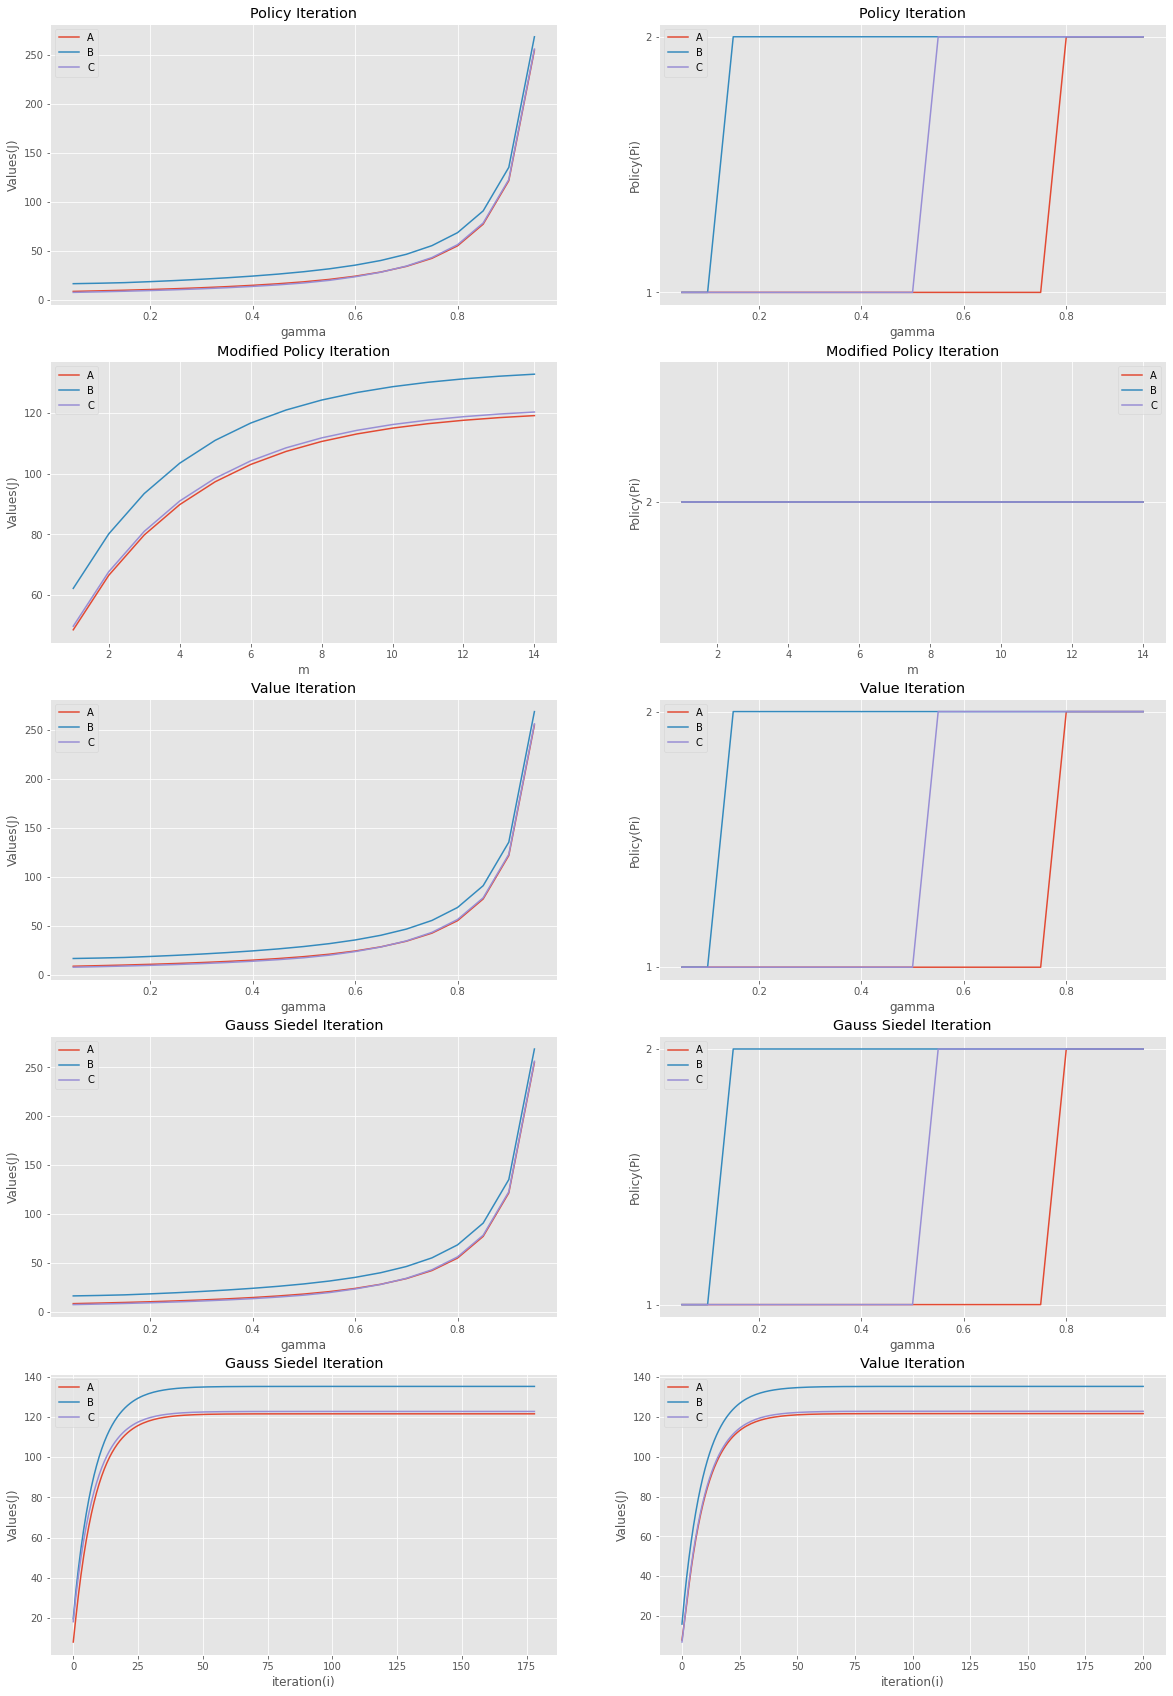

In [ ]:
## Visualize policy iteration with multiple values of gamma
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9, ax10)) = plt.subplots(5,2,figsize=(20,30))

results, extra_info = run_policy_iteration(env)
keys = list(results.keys())
values = {state:[] for state in list(results[keys[0]]['Expected Reward'].keys())}
policy = {state:[] for state in list(results[keys[0]]['Policy'].keys())}
for key in keys:
  for state in list(results[key]['Expected Reward'].keys()):
    values[state].append(results[key]['Expected Reward'][state])
    policy[state].append(results[key]['Policy'][state])
for key in list(values.keys()):
  ax1.plot(keys, values[key], label=key)
  ax2.plot(keys, policy[key], label=key)
ax1.title.set_text('Policy Iteration')
ax2.title.set_text('Policy Iteration')
ax1.set_xlabel('gamma')
ax1.set_ylabel('Values(J)')
ax2.set_xlabel('gamma')
ax2.set_ylabel('Policy(Pi)')
ax1.legend()
ax2.legend()

results, extra_info = run_modified_policy_iteration(env)
keys = list(results.keys())
values = {state:[] for state in list(results[keys[0]]['Expected Reward'].keys())}
policy = {state:[] for state in list(results[keys[0]]['Policy'].keys())}
for key in keys:
  for state in list(results[key]['Expected Reward'].keys()):
    values[state].append(results[key]['Expected Reward'][state])
    policy[state].append(results[key]['Policy'][state])
for key in list(values.keys()):
  ax3.plot(keys, values[key], label=key)
  ax4.plot(keys, policy[key], label=key)
ax3.title.set_text('Modified Policy Iteration')
ax4.title.set_text('Modified Policy Iteration')
ax3.set_xlabel('m')
ax3.set_ylabel('Values(J)')
ax4.set_xlabel('m')
ax4.set_ylabel('Policy(Pi)')
ax3.legend()
ax4.legend()

results, extra_info = run_value_iteration(env)
keys = list(results.keys())
values = {state:[] for state in list(results[keys[0]]['Expected Reward'].keys())}
policy = {state:[] for state in list(results[keys[0]]['Policy'].keys())}
for key in keys:
  for state in list(results[key]['Expected Reward'].keys()):
    values[state].append(results[key]['Expected Reward'][state])
    policy[state].append(results[key]['Policy'][state])
for key in list(values.keys()):
  ax5.plot(keys, values[key], label=key)
  ax6.plot(keys, policy[key], label=key)
ax5.title.set_text('Value Iteration')
ax6.title.set_text('Value Iteration')
ax5.set_xlabel('gamma')
ax5.set_ylabel('Values(J)')
ax6.set_xlabel('gamma')
ax6.set_ylabel('Policy(Pi)')
ax5.legend()
ax6.legend()

results, extra_info = run_gauss_seidel_value_iteration(env)
keys = list(results.keys())
values = {state:[] for state in list(results[keys[0]]['Expected Reward'].keys())}
policy = {state:[] for state in list(results[keys[0]]['Policy'].keys())}
for key in keys:
  for state in list(results[key]['Expected Reward'].keys()):
    values[state].append(results[key]['Expected Reward'][state])
    policy[state].append(results[key]['Policy'][state])
for key in list(values.keys()):
  ax7.plot(keys, values[key], label=key)
  ax8.plot(keys, policy[key], label=key)
ax7.title.set_text('Gauss Siedel Iteration')
ax8.title.set_text('Gauss Siedel Iteration')
ax7.set_xlabel('gamma')
ax7.set_ylabel('Values(J)')
ax8.set_xlabel('gamma')
ax8.set_ylabel('Policy(Pi)')
ax7.legend()
ax8.legend()

results1 = gauss_seidel_value_iteration(env, 0.9)[1]
results2 = value_iteration(env, 0.9)[1]
values1 = results1['values']
values2 = results2['values']
rewards1 = {state:[] for state in list(values1[0].keys())}
rewards2 = {state:[] for state in list(values2[0].keys())}
for value in values1:
  for state in list(value.keys()):
    rewards1[state].append(value[state])
for value in values2:
  for state in list(value.keys()):
    rewards2[state].append(value[state])
for key in list(rewards1.keys()):
  ax9.plot(range(len(rewards1[key])), rewards1[key], label=key)
for key in list(rewards2.keys()):
  ax10.plot(range(len(rewards2[key])), rewards2[key], label=key)
ax9.title.set_text('Gauss Siedel Iteration')
ax10.title.set_text('Value Iteration')
ax9.set_xlabel('iteration(i)')
ax9.set_ylabel('Values(J)')
ax10.set_xlabel('iteration(i)')
ax10.set_ylabel('Values(J)')
ax9.legend()
ax10.legend()

plt.show()

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

From the first row left graph, we can observe that as the gamma increases the values also increases, the growth seems to be exponential intuitively. This can also be intuitively understandable because as the discount factor decreases the future approximations are increasingly negligible and the values tend to decrease with it. From the first row right graph, we can see that policy too changes for different states with different gammas. As the gamma increases the optimal policy for every state tend to reach action 2 from action 1 and stay put.

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

From the second row left graph, we can observe that the values of each state tend to converge as m increases, here m=10 is not a special value to be considered but it is obviously better than m=5 or 4. We intuitively know that as many times we do value iteration it tend to converge more towards the final J(Pi) with lesser error. From the second row right graph we can observe that irrespective of all the values of m, policy is converged for all the states, so m=10 doesn't make any special pogress. Therefore we can conclude that m=10 provides better values than other m which are less than 10.  

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

From the fifth row left and right graph we can concretely observe that both value iteration and gauss siedel converges to the same points but gauss seidel converges faster than value iteration. Gauss Seidel take 175 iterations approx to converge but Value iteration took 200 iterations approx to converge. From code we can observe that both gauss seidel and value iteration has the same complexity, when we take number of iterations to converge into account then Gauss Seidel is obviously faster and effecient than Value Iteration Algorithm. From the 3rd and 4th row graphs both value iteration and gauss seidel tend to converge to same values and policies irrespective of different gamma values. We can finally infer that gauss seidel and value iteration are very similar algorithm and they do the same job exactly, the difference is gauss seidel is computationally faster than value iteration.

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20Copy%20of%20IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4pnN0163HiIRLjH1FLzSuK8J8Hk9s_5O5IwnCxRD5I15Aru13APFw
Mo